In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.signal import correlate, fftconvolve, correlate
from scipy.stats import norm, kendalltau, spearmanr, pearsonr
from scipy.optimize import curve_fit
from tqdm import tqdm

In [81]:
def add_noise(flux, SNR=300):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise


def shift_array(arr, n, fill_value=0):
    """Shift an array by n elements (left or right)."""
    result = np.empty_like(arr)
    if n > 0:
        result[:n] = fill_value
        result[n:] = arr[:-n]
    elif n < 0:
        result[n:] = fill_value
        result[:n] = arr[-n:]
    else:
        result[:] = arr
    return result


def new_detect_molecule(wavelength, spectrum, specie_spectrum, clip_min=4.9, clip_max=27.5, peak_shift=0, window=300,
                    exclude=20, title=None, plot=False, n_trials=1000):
    if len(wavelength) != len(spectrum) | len(wavelength) != len(specie_spectrum):
        print('Error: wavelength, spectrum and specie_spectrum must be the same length')
        return

    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)

    # center_index = len(wavelength[feature_mask]) // 2

    lags = np.arange(-len(spectrum[feature_mask]) + 1, len(spectrum[feature_mask]))
    cc = correlate(spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac = correlate(specie_spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac /= ac[len(ac) // 2]
    center_index = len(lags) // 2
    lag_indices = np.arange(center_index - window, center_index + window + 1)

    # plt.plot(correlate(ac, cc))
    # plt.show()
    X = ac[lag_indices]
    Y = cc[lag_indices]
    X = shift_array(X, peak_shift)
    # print(pearsonr(X, Y))
    lags_window = lags[lag_indices] - lags[center_index + peak_shift]
    noise_mask = (lags_window < -exclude) | (lags_window > exclude)

    weights = np.exp(-(lags_window) ** 2 / 2)
    # print(weights)
    factor = np.sum(X[~noise_mask]*Y[~noise_mask])/np.sum(X[~noise_mask]**2)
    model = factor * X
    residual = Y - model

    mid = len(Y) // 2
    test_s = Y[mid]-np.median(Y[~noise_mask])
    test_s_list = []
    for _ in range(n_trials):
        # shift = np.random.randint(1, len(spectrum[feature_mask]))  # avoid shift = 0
        # spectrum_shifted = np.roll(spectrum[feature_mask], shift)
        cc_new = correlate(np.random.choice(spectrum[feature_mask], size=len(spectrum[feature_mask]), replace=True), specie_spectrum[feature_mask], mode='full')
        # factor = np.sum(X[~noise_mask]*cc_new[lag_indices][~noise_mask])/np.sum(X[~noise_mask]**2)
        # model = factor * X
        # plt.plot(lags[lag_indices], cc_new[lag_indices])
        # plt.plot(lags[lag_indices], cc[lag_indices])
        # plt.show()
        test_s_list.append(cc_new[lag_indices][mid]-np.median(cc_new[lag_indices][~noise_mask]))
    test_s_list = np.array(test_s_list)
    p = round(1 - len(test_s_list[test_s_list<test_s])/n_trials, int(np.log10(n_trials)))
    if plot:
        plt.plot(lags_window, Y, label='Cross-correlation')
        # plt.plot(lags_window, X*Y[mid], label='Fitted Auto-correlation')
        # plt.plot(lags_window, residual, label='Residual')
        plt.axvline(peak_shift, color='gray', linestyle='--', label='Peak')
        plt.axhline(0, color='gray', linestyle=':')
        plt.axvline(-exclude, color='red', linestyle='--')
        plt.axvline(exclude, color='red', linestyle='--', label='Window')
        plt.title(f'Cross-correlation {title}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xlim(-window, window)
        plt.grid(True)
        plt.show()
        plt.title(title + ' ' + str(p))
        plt.hist(test_s_list, density=True)
        plt.axvline(test_s, color='red')
        plt.xlabel('Difference Peak and Median')
        plt.ylabel('Probability Density')
        plt.show()
    return p

def fit_spectrum(wavelength, spectrum, specie_spectrum, clip_min=4.9, clip_max=27.5, peak_shift=0):
    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)
    factor = np.sum(spectrum[feature_mask]*specie_spectrum[feature_mask])/np.sum(specie_spectrum[feature_mask]**2)
    return factor*specie_spectrum

In [3]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

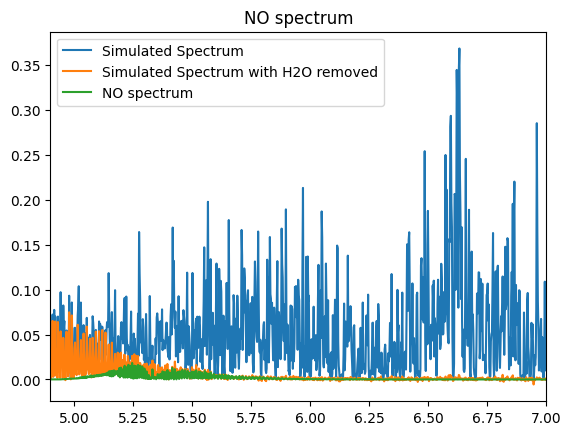

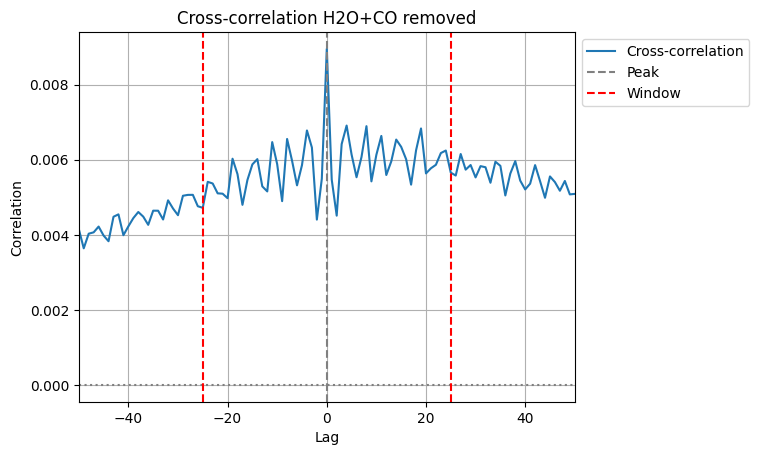

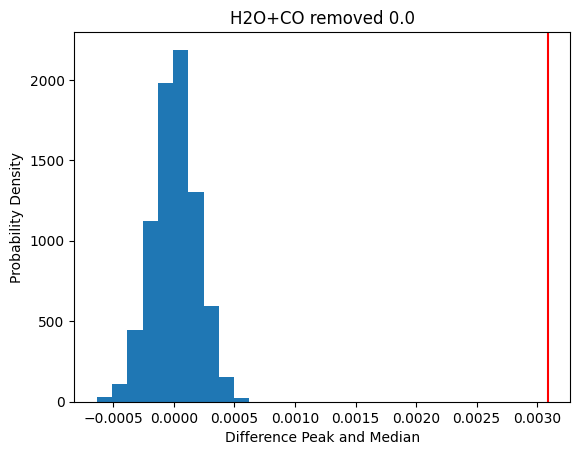

NO detected:  True


In [87]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
species = ['NO']
total_wl = np.linspace(4.9, 27.5, 10000)
clip_min, clip_max = 4.9, 7
mask = np.logical_and(total_wl > clip_min, total_wl < clip_max)
for target in species:
    for i, row in df.iterrows():
        if i != 14:
            continue
        wavelength = row['FLiTs Wavelength']
        flux_cont_sub = row['FLiTs Flux']
        continuum = row['FLiTs Flux Continuum']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = row['FLiTs NH3 Flux']
        NH3_flux = np.interp(total_wl, NH3_wl, NH3_flux)
        flux_cont_sub = np.interp(total_wl, wavelength, flux_cont_sub) + NH3_flux
        continuum = np.interp(total_wl, wavelength, continuum)
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=300) - continuum
        target_wl = row[f'FLiTs {target} Wavelength']
        target_flux = row[f'FLiTs {target} Flux']
        target_flux = np.interp(total_wl, target_wl, target_flux)
        CO_wl = row['FLiTs CO Wavelength']
        CO_flux = row['FLiTs CO Flux']
        CO_flux = np.interp(total_wl, CO_wl, CO_flux)
        H2O_wl = row['FLiTs H2O Wavelength']
        H2O_flux = row['FLiTs H2O Flux']
        H2O_flux = np.interp(total_wl, H2O_wl, H2O_flux)
        plt.plot(total_wl[mask], (flux_cont_sub)[mask], label='Simulated Spectrum')
        plt.plot(total_wl[mask], (flux_cont_sub-H2O_flux)[mask], label='Simulated Spectrum with H2O removed')
        plt.plot(total_wl[mask], target_flux[mask], label='NO spectrum')
        plt.title(f'{target} spectrum')
        plt.xlim(clip_min, clip_max)
        plt.legend()
        plt.show()
        print(target + ' detected: ', new_detect_molecule(total_wl, flux_cont_sub-H2O_flux-CO_flux, target_flux, clip_min=clip_min, clip_max=clip_max, peak_shift=0,
                        window=50,
                        exclude=25, title=f'H2O+CO removed', plot=True)<0.05)
        # print(target + ' detected: ', new_detect_molecule(total_wl, flux_cont_sub-target_flux, target_flux, clip_min=clip_min, clip_max=clip_max,
        #                 peak_shift=0, window=50,
        #                 exclude=25, title=f'{target} Flux Removed:', plot=True, n_trials=100000)<0.05)
        # print(target + ' detected: ', new_detect_molecule(total_wl, flux_cont_sub+2*target_flux, target_flux, clip_min=clip_min, clip_max=clip_max, peak_shift=0,
        #                 window=50,
        #                 exclude=25, title=f'3x {target} Flux Present:', plot=True, n_trials=100000)<0.05)

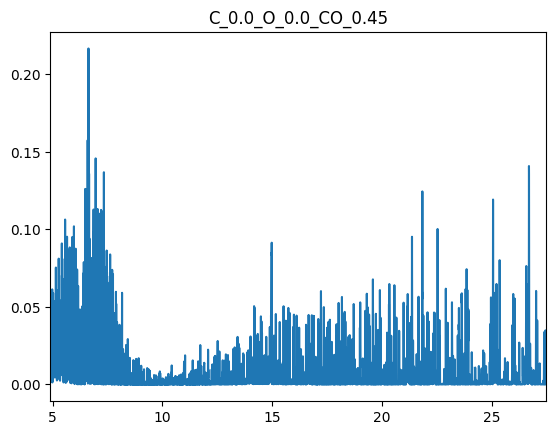

C2H2 detected when present:  False
C2H2 detected when absent :  False
CO detected when present:  True
CO detected when absent :  False
CO2 detected when present:  True
CO2 detected when absent :  False
H2O detected when present:  True
H2O detected when absent :  False
HCN detected when present:  False
HCN detected when absent :  False
NH3 detected when present:  False
NH3 detected when absent :  False
NO detected when present:  False
NO detected when absent :  False
OH detected when present:  True
OH detected when absent :  False


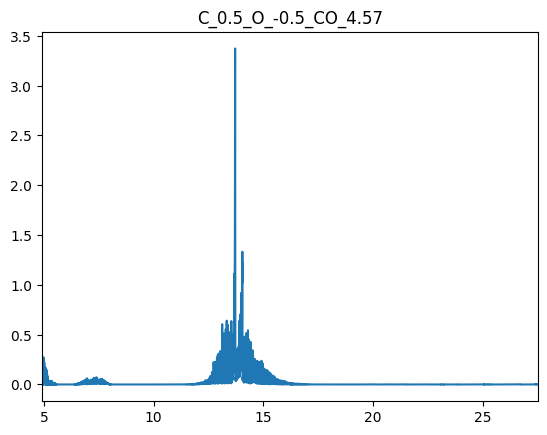

C2H2 detected when present:  True
C2H2 detected when absent :  False
CO detected when present:  True
CO detected when absent :  False
CO2 detected when present:  False
CO2 detected when absent :  False
H2O detected when present:  False
H2O detected when absent :  False
HCN detected when present:  True
HCN detected when absent :  True
NH3 detected when present:  False
NH3 detected when absent :  False
NO detected when present:  False
NO detected when absent :  False
OH detected when present:  False
OH detected when absent :  False


In [5]:
species = ['C2H2','CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
# species = ['HCN']
total_wl = np.linspace(4.9, 27.5, 10000)
clip_min, clip_max = 4.9, 27.5
for i, row in df.iterrows():
    if i not in [12, 20]:
        continue
    wavelength = row['FLiTs Wavelength']
    flux_cont_sub = row['FLiTs Flux']
    NH3_wl = row['FLiTs NH3 Wavelength']
    NH3_flux = row['FLiTs NH3 Flux']
    NH3_flux = np.interp(total_wl, NH3_wl, NH3_flux)
    flux_cont_sub = np.interp(total_wl, wavelength, flux_cont_sub) + NH3_flux
    plt.plot(total_wl, flux_cont_sub)
    plt.title(row['Model Name'])
    plt.xlim(clip_min, clip_max)
    plt.show()
    for target in species:
        wavelength = row['FLiTs Wavelength']
        flux_cont_sub = row['FLiTs Flux']
        continuum = row['FLiTs Flux Continuum']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = row['FLiTs NH3 Flux']
        NH3_flux = np.interp(total_wl, NH3_wl, NH3_flux)
        flux_cont_sub = np.interp(total_wl, wavelength, flux_cont_sub) + NH3_flux
        continuum = np.interp(total_wl, wavelength, continuum)
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=300) - continuum
        target_wl = row[f'FLiTs {target} Wavelength']
        target_flux = row[f'FLiTs {target} Flux']
        target_flux = np.interp(total_wl, target_wl, target_flux)
        print(target + ' detected when present: ', new_detect_molecule(total_wl, flux_cont_sub, target_flux, clip_min=clip_min, clip_max=clip_max, peak_shift=0,
                        window=300,
                        exclude=90, title=f'{target}Present')<0.05)
        print(target + ' detected when absent : ', new_detect_molecule(total_wl, flux_cont_sub-target_flux, target_flux, clip_min=clip_min, clip_max=clip_max,
                        peak_shift=0, window=300,
                        exclude=90, title=f'{target}Not Present')<0.05)

In [56]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
avg_flux = {}
total_wl = wavelength
for specie in species:
    total_flux = np.zeros_like(total_wl)
    for i,row in df.iterrows():
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(total_wl, specie_wl, specie_flux)
        total_flux += specie_flux
    total_flux /= 25
    avg_flux.update({specie:total_flux})

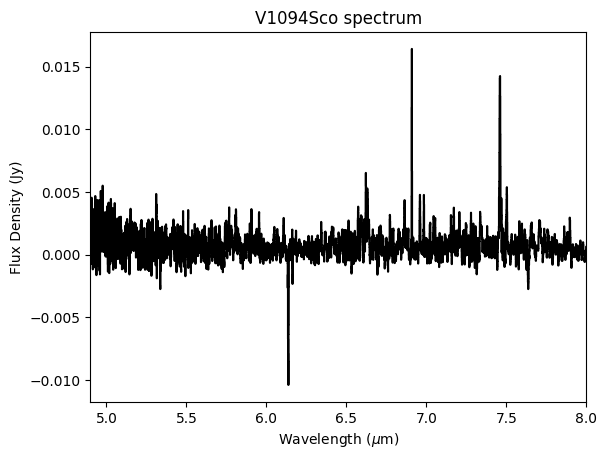

V1094Sco-----------
     C2H2 detected:  False
     CH4 detected:  True
     CO detected:  True
     CO2 detected:  False
     H2O detected:  True
     HCN detected:  False
     NH3 detected:  False
     NO detected:  False
     OH detected:  False
     NO detected:  True


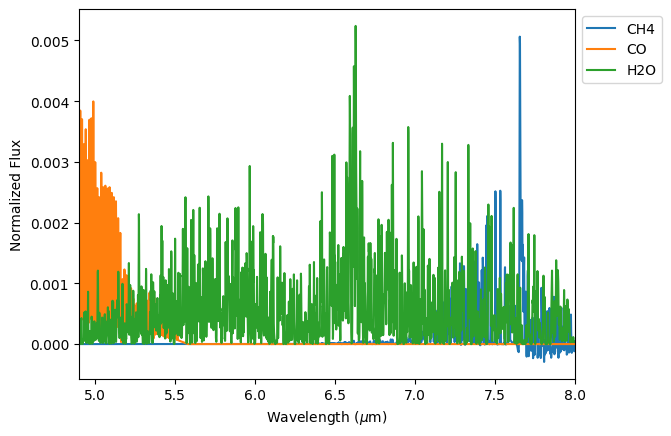

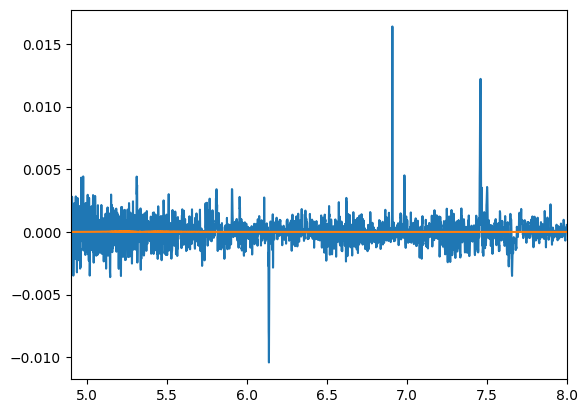

In [64]:
clip_min, clip_max = 4.9, 8
species = ['C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
for Source in ['V1094Sco']:
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']

    mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)

    plt.step(wavelength[mask], flux_cont_sub[mask], c='black')
    plt.title(f'{Source} spectrum')
    plt.xlim(clip_min, clip_max)
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel('Flux Density (Jy)')
    plt.show()
    print(Source + '-----------')
    detected_molecules = []
    for target in species:
        p = new_detect_molecule(wavelength, flux_cont_sub, avg_flux[target], clip_min=clip_min, clip_max=clip_max, peak_shift=0,
                        window=300,
                        exclude=90, title=f'{target}Present')
        print('     ' + target + ' detected: ', p<0.05)
        if p<0.05:
            detected_molecules.append(target)
    total = flux_cont_sub.copy()
    for target in detected_molecules:
        if target=='NO':
            continue
        total -= fit_spectrum(wavelength, flux_cont_sub, avg_flux[target],clip_min=clip_min, clip_max=clip_max, peak_shift=0)
        plt.plot(wavelength[mask], fit_spectrum(wavelength, flux_cont_sub, avg_flux[target],clip_min=clip_min, clip_max=clip_max, peak_shift=0)[mask], label=target)
    p = new_detect_molecule(wavelength, total, avg_flux['NO'], clip_min=clip_min, clip_max=clip_max, peak_shift=0,
                        window=300,
                        exclude=90, title=f'NOPresent')
    print('     ' + 'NO' + ' detected: ', p<0.05)
    plt.xlim(clip_min, clip_max)
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel('Normalized Flux')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    plt.plot(wavelength[mask], total[mask])
    plt.plot(wavelength[mask], fit_spectrum(wavelength, total, avg_flux['NO'],clip_min=clip_min, clip_max=clip_max, peak_shift=0)[mask])
    plt.xlim(clip_min, clip_max)
    plt.show()

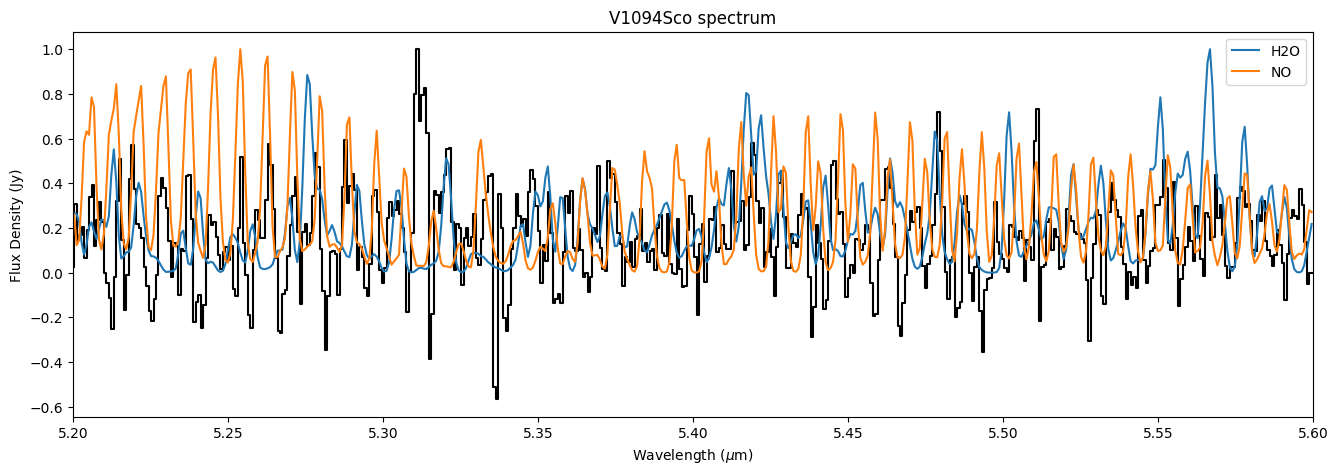

In [93]:
clip_min, clip_max = 5.2, 5.6
plt.figure(figsize=(16, 5))
for Source in ['V1094Sco']:
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']
    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)
    plt.step(wavelength[feature_mask], flux_cont_sub[feature_mask]/max(flux_cont_sub[feature_mask]), c='black')
    plt.title(f'{Source} spectrum')
    plt.xlim(clip_min, clip_max)
    # plt.xlabel(r'Wavelength ($\mu$m)')
    # plt.ylabel('Flux Density (Jy)')
    # plt.show()
    for target in ['H2O', 'NO']:
        plt.plot(wavelength[feature_mask], avg_flux[target][feature_mask]/max(avg_flux[target][feature_mask]), label=target)
    plt.xlim(clip_min, clip_max)
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel('Flux Density (Jy)')
    plt.legend()
    plt.show()

In [91]:
artefact_regions = [[5.0091,5.01071], [5.018,5.019], [5.112,5.15],
[5.2157,5.2184], [5.2267,5.2290], [5.2441,5.2471],
[5.2947,5.2974], [5.3742,5.3777], [5.3836,5.3877],
[5.4181,5.4210], [5.5644,5.5674], [5.5925,5.5966],
[5.8252,5.8267], [5.8669,5.8689], [5.9,5.916], [5.9282,5.9314],
[5.9691,5.9728], [6.0357,6.0394], [6.0430,6.0462],
[6.1012,6.1044], [6.1311,6.1421], [6.26,6.31], [6.3740,6.3757],
[6.3783,6.3810], [18.8055,18.8145], [19.004,19.012],
[21.974,21.985], [25.69824,25.71313]]

In [96]:
def mask_regions(wavelength, flux, regions):
    new_flux = flux.copy()
    for region in regions:
        new_flux[np.logical_and(wavelength > region[0], wavelength < region[1])] = np.nan
    return new_flux

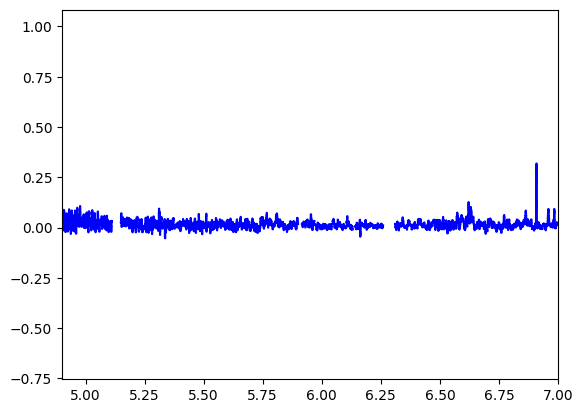

In [101]:
plt.step(wavelength, mask_regions(wavelength, flux_cont_sub/max(flux_cont_sub), artefact_regions), c='b')
plt.xlim(4.9, 7)
plt.show()